In [1]:
import sys, glob, itertools
import numpy as np
import qiskit

import networkx as nx
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

import utils.graph_funcs as graph_funcs
import utils.helper_funcs as helper_funcs
import utils.cutting_funcs as cutting_funcs

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm
import qsplit_dqva_methods as qdm

from ansatz import dqv_cut_ansatz

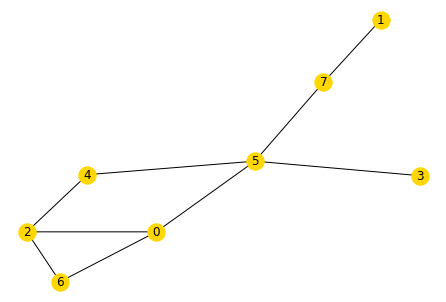

In [2]:
test_graphs = glob.glob("benchmark_graphs/N8_p30_graphs/*")
#test_graph = np.random.choice(test_graphs)
G = graph_funcs.graph_from_file(test_graphs[0])
qubit_num = G.number_of_nodes()
nx.draw_spring(G, with_labels=True, node_color='gold')

Partition: ({0, 2, 4, 6}, {1, 3, 5, 7})
Cut edges: [(0, 5), (5, 4)]
Cut nodes: [0, 5, 5, 4] Hot nodes: [0, 4]


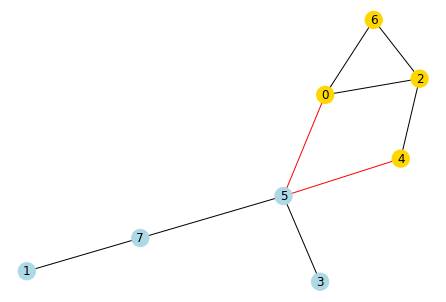

In [3]:
partition = kernighan_lin_bisection(G)
print('Partition:', partition)
subgraphs, cut_edges = graph_funcs.get_subgraphs(G, partition)
cut_nodes, hot_nodes = cutting_funcs.choose_nodes(G, subgraphs, cut_edges, max_cuts=1)
print('Cut edges:', cut_edges)
print('Cut nodes:', cut_nodes, 'Hot nodes:', hot_nodes)
graph_funcs.view_partition(partition, G)

In [48]:
nq = len(G.nodes())
P = 1
shots = 500000
init_state = '0'*nq
init_state = '00000000'
print('Initial state:', init_state)

num_params = P * (nq + 1)

mixer_order = list(np.random.permutation(list(G.nodes)))
print('mixer order:', mixer_order)
print()

Initial state: 00000000
mixer order: [3, 0, 2, 4, 5, 7, 6, 1]



In [57]:
def get_circuit_and_cuts(num_params, init_state, mixer_order):

    params = [qiskit.circuit.Parameter('var_{}'.format(num)) for num in range(num_params)]
    print('params:', params)

    kwargs = dict(params=params, init_state=init_state, mixer_order=mixer_order,
                  decompose_toffoli=1, verbose=1, P=P, barriers=2)
    
    circuit, cuts = dqv_cut_ansatz.gen_dqva(G, partition, cut_nodes, hot_nodes, **kwargs)
    print(cuts)
    fragments, wire_path_map = qcc.cut_circuit(circuit, cuts)
    
    return circuit, cuts, fragments, wire_path_map

In [58]:
circuit, cuts, fragments, wire_path_map = get_circuit_and_cuts(num_params, init_state, mixer_order)
print('Cuts:', cuts)
print('Fragments:', fragments)
print('wire path map:', wire_path_map)
circuit.draw(fold=-1)

params: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8)]
Parameters:
	alpha_0: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7)]
	gamma_0: var_8
APPLYING MIXER UNITARY
	Mixer order: [0, 2, 4, 6, 3, 5, 7, 1] Cut nodes: [0, 5, 5, 4] Hot nodes: [0, 4]
	init_state: 00000000
	alpha: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7)]
	pad_alpha: [Parameter(var_0), Parameter(var_6), Parameter(var_1), Parameter(var_4), Parameter(var_2), None, Parameter(var_3), Parameter(var_5)]
	Swap qubit = 3
	qubit: 0 num_qubits = 10 neighbors: [2, 5, 6]
	qubit: 2 num_qubits = 10 neighbors: [0, 4, 6]
	qubit: 4 num_qubits = 10 neighbors: [2, 5]
	qubit: 6 num_qubits = 10 neighbors: [0, 2]
	cuts: [(Qubit(QuantumRe

░                ┌─────────────┐                ░ ┌───┐     ┌───┐     ┌───┐               ┌───┐ ░                                               ░ ┌───┐          ┌───┐     ┌───┐     ┌───┐ ░                                               ░                                          ░                                               ░  ░ ┌─────────────┐ ░ 
  q_0: ─░────────────────┤ RX(2*var_0) ├────────────────░─┤ X ├──■──┤ X ├─────┤ X ├────────────■──┤ X ├─░───────────────────────────────────────────────░─┤ X ├──■───────┤ X ├─────┤ X ├──■──┤ X ├─░───────────────────────────────────────────────░──────────────────────────────────────────░───────────────────────────────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░                └──────┬──────┘                ░ └───┘  │  └───┘     └───┘            │  └───┘ ░                                               ░ └───┘  │       └───┘     └───┘  │  └───┘ ░                                               ░ ┌───┐          ┌───┐     ┌───┐     ┌───┐ ░                ┌─────────────┐                ░  ░ ├─────────────┤ ░ 
  q_1: ─░───────────────────────┼───────────────────────░────────┼─────────────────────────────┼────────░───────────────────────────────────────────────░────────┼────────────────────────┼────────░───────────────────────────────────────────────░─┤ X ├──■───────┤ X ├─────┤ X ├──■──┤ X ├─░────────────────┤ RX(2*var_6) ├────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░ ┌───┐     ┌───┐       │       ┌───┐     ┌───┐ ░        │       ┌─────────────┐       │        ░ ┌───┐     ┌───┐     ┌───┐               ┌───┐ ░ ┌───┐  │       ┌───┐     ┌───┐  │  ┌───┐ ░                                               ░ └───┘  │       └───┘     └───┘  │  └───┘ ░                └──────┬──────┘                ░  ░ ├─────────────┤ ░ 
  q_2: ─░─┤ X ├──■──┤ X ├───────┼───────┤ X ├──■──┤ X ├─░────────┼───────┤ RX(2*var_1) ├───────┼────────░─┤ X ├──■──┤ X ├─────┤ X ├────────────■──┤ X ├─░─┤ X ├──■───────┤ X ├─────┤ X ├──■──┤ X ├─░───────────────────────────────────────────────░────────┼────────────────────────┼────────░───────────────────────┼───────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░ └───┘  │  └───┘       │       └───┘  │  └───┘ ░        │       └──────┬──────┘       │        ░ └───┘  │  └───┘     └───┘            │  └───┘ ░ └───┘  │       └───┘     └───┘  │  └───┘ ░                ┌─────────────┐                ░        │                        │        ░                       │                       ░  ░ ├─────────────┤ ░ 
  q_3: ─░────────┼──────────────┼──────────────┼────────░────────┼──────────────┼──────────────┼────────░────────┼─────────────────────────────┼────────░────────┼────────────────────────┼────────░────────────────┤ RX(2*var_4) ├────────────────░────────┼────────────────────────┼────────░───────────────────────┼───────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░        │              │              │        ░ ┌───┐  │  ┌───┐       │       ┌───┐  │  ┌───┐ ░        │       ┌─────────────┐       │        ░        │                        │        ░                └──────┬──────┘                ░        │                        │        ░                       │                       ░  ░ ├─────────────┤ ░ 
  q_4: ─░────────┼──────────────┼──────────────┼────────░─┤ X ├──■──┤ X ├───────┼───────┤ X ├──■──┤ X ├─░────────┼───────┤ RX(2*var_2) ├───────┼────────░────────┼────────────────────────┼────────░───────────────────────┼───────────────────────░────────┼────────────────────────┼────────░───────────────────────┼───────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░ ┌───┐  │  ┌───┐       │       ┌───┐  │  ┌───┐ ░ └───┘  │  └───┘       │       └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐└──────┬──────┘┌───┐  │  ┌───┐ ░        │                        │        ░ ┌───┐     ┌───┐       │       ┌───┐     ┌───┐ ░ ┌───┐  │       ┌───┐     ┌───┐  │  ┌───┐ ░                       │                       ░  ░ ├─────────────┤ ░ 
  q_5: ─░─┤ X ├──■──┤ X ├───────┼───────┤ X ├──■──┤ X ├─░────────┼────

In [59]:
def digit_substr(string):
    return "".join(filter(str.isdigit, string))

def bind(circuit, params):
    binding = {circuit_param : params[int(digit_substr(circuit_param.name))]
               for circuit_param in circuit.parameters}
    return circuit.bind_parameters(binding)

def get_circuit_output(params, var_fragments, wire_path_map, frag_shots):
    fragments = [bind(fragment, params) for fragment in var_fragments]
    recombined_dist = cutting_funcs.sim_with_cutting(fragments, wire_path_map, frag_shots, backend)
    return recombined_dist

In [60]:
frag_shots = shots // qmm.fragment_variants(wire_path_map)
print(frag_shots)
init_params = np.arange(1, num_params+1)
backend = qiskit.Aer.get_backend('statevector_simulator')
recombined_dist = get_circuit_output(init_params, fragments, wire_path_map, frag_shots)
print(recombined_dist)

full_circuit = bind(circuit, init_params)
result = qiskit.execute(full_circuit, backend=backend).result()
sv = result.get_statevector(full_circuit)
exact_dist = qiskit.quantum_info.Statevector(sv).probabilities_dict(decimals=5)
print()
print(exact_dist)

print(qiskit.quantum_info.hellinger_fidelity(recombined_dist, exact_dist))

71428
Model time: 3.390, Recombine time: 0.013
{'0000100001': 0.05271767544211459, '0000100011': 0.05271767544211459, '0010001001': 0.03376690649330689, '0000001001': 0.07022724175966395, '0000000011': 0.017353393299531002, '0000001011': 0.07022724175966394, '0000110001': 0.0523410046888178, '0000110011': 0.0523410046888178, '0010011001': 0.07298632815736361, '0000011001': 0.06442565918652497, '0000010011': 0.036421202423602646, '0000011011': 0.06442565918652496, '0001100000': 0.018341716610884882, '0001100010': 0.018341716610884882, '0011001000': 0.022081628581670582, '0001001000': 0.014312933417572738, '0001000010': 0.01665883275600884, '0001001010': 0.014312933417572735, '0000100100': 0.036512693042546486, '0000100110': 0.036512693042546486, '0010001100': 0.02030824755467765, '0000001100': 0.02849262997031043, '0000000110': 0.001630591102372631, '0000001110': 0.02849262997031043, '0000100000': 0.018341716610884882, '0000100010': 0.018341716610884882, '0010001000': 0.0220816285816705

In [75]:
# Build a simple circuit
my_circ = qiskit.QuantumCircuit(3, name='q')
my_circ.h(0)
my_circ.cx(0,1)
my_circ.cx(1,2)

# Cut it after the first CNOT on qubit 1
cuts = [(qiskit.circuit.Qubit(qiskit.QuantumRegister(3, 'q'), 1), 1)]
print(cuts)
print(my_circ)

# Cut the circuit
fragments, wire_path_map = qcc.cut_circuit(my_circ, cuts)
for i, frag in enumerate(fragments):
    print('Fragment', i+1)
    print(frag)
shots = 100000
frag_shots = shots // qmm.fragment_variants(wire_path_map)
print('frag shots:', frag_shots)

# Simulate and recombine
backend = qiskit.Aer.get_backend('statevector_simulator')
recombined_dist = cutting_funcs.sim_with_cutting(fragments, wire_path_map, frag_shots, backend)
print(recombined_dist)

# Evaluate the original circuit for comparison
result = qiskit.execute(my_circ, backend=backend).result()
sv = result.get_statevector(my_circ)
exact_dist = qiskit.quantum_info.Statevector(sv).probabilities_dict(decimals=5)
print()
print(exact_dist)

# Compute the Hellinger Fidelity
print('Hellinger fidelity:', qiskit.quantum_info.hellinger_fidelity(recombined_dist, exact_dist))

[(Qubit(QuantumRegister(3, 'q'), 1), 1)]
     ┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘
Fragment 1
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
Fragment 2
          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
frag shots: 142857
Model time: 3.737, Recombine time: 0.003
{'001': 0.2857142857142856, '111': 0.3428571428571429, '000': 0.28571428571428564, '110': 0.08571428571428578}

{'000': 0.5, '111': 0.5}
Hellinger fidelity: 0.5439340054494741


In [ ]:
def avg_cost(params, *args):
    probs = get_circuit_output(params, *args)

In [ ]:
args = (fragments, wire_path_map, frag_shots)
init_params = np.random.uniform(low=0.0, high=2*np.pi, size=num_params)
out = minimize(avg_cost, init_params, args=args, method='COBYLA')